In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## noncyclic Stocks

### Kweichow Moutai Co., Ltd.

In [6]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [7]:
df.set_index('Date', inplace=True)

In [8]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(4111, 10, 4)

In [10]:
v = X.reshape(X.shape[0],10, 4)
v[0]

array([[0.04629628, 1.        , 0.88377369, 0.26339845],
       [0.42592662, 0.85852841, 0.61591486, 0.57543551],
       [0.        , 0.34992569, 0.        , 0.21007723],
       [0.37963257, 0.26619634, 0.37963257, 0.64820202],
       [1.        , 0.7617803 , 1.        , 1.        ],
       [0.7129622 , 0.91903823, 0.7129622 , 0.54560442],
       [0.20370317, 0.58711924, 0.20370317, 0.22515359],
       [0.19444525, 0.29781169, 0.24739117, 0.05969262],
       [0.36111006, 0.20518775, 0.6412213 , 0.20156019],
       [0.22222124, 0.        , 0.72245047, 0.        ]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4111,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 34ms/step - loss: 0.2965 - accuracy: 0.5076 - mse: 0.4261 - weighted_accuracy: 0.3391 - weighted_mse: 0.4927 - val_loss: 0.3011 - val_accuracy: 0.0450 - val_mse: 0.3483 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3483
Epoch 2/200
26/26 [==============================] - 0s 7ms/step - loss: 0.2116 - accuracy: 0.3452 - mse: 0.7110 - weighted_accuracy: 0.4942 - weighted_mse: 0.6838 - val_loss: 0.2940 - val_accuracy: 0.0450 - val_mse: 0.3749 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3749
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1845 - accuracy: 0.2381 - mse: 0.9880 - weighted_accuracy: 0.5409 - weighted_mse: 0.9067 - val_loss: 0.2843 - val_accuracy: 0.0450 - val_mse: 0.4097 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4097
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1735 - accuracy: 0.2293 - mse: 1.1751 - weighted_accuracy: 0.5504 - weighte

Epoch 30/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1295 - accuracy: 0.4443 - mse: 1.7671 - weighted_accuracy: 0.7322 - weighted_mse: 1.7082 - val_loss: 0.1891 - val_accuracy: 0.3779 - val_mse: 1.6670 - val_weighted_accuracy: 0.3779 - val_weighted_mse: 1.6670
Epoch 31/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1281 - accuracy: 0.4614 - mse: 1.7809 - weighted_accuracy: 0.7450 - weighted_mse: 1.7281 - val_loss: 0.1926 - val_accuracy: 0.3621 - val_mse: 1.6648 - val_weighted_accuracy: 0.3621 - val_weighted_mse: 1.6648
Epoch 32/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1274 - accuracy: 0.4675 - mse: 1.8058 - weighted_accuracy: 0.7536 - weighted_mse: 1.7618 - val_loss: 0.1895 - val_accuracy: 0.3876 - val_mse: 1.6873 - val_weighted_accuracy: 0.3876 - val_weighted_mse: 1.6873
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1267 - accuracy: 0.4675 - mse: 1.8286 - weighted_accuracy: 0.7408 - weig

Epoch 59/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1043 - accuracy: 0.6116 - mse: 2.3130 - weighted_accuracy: 0.8236 - weighted_mse: 2.3315 - val_loss: 0.1797 - val_accuracy: 0.4970 - val_mse: 2.4694 - val_weighted_accuracy: 0.4970 - val_weighted_mse: 2.4694
Epoch 60/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1024 - accuracy: 0.5961 - mse: 2.3657 - weighted_accuracy: 0.8307 - weighted_mse: 2.3877 - val_loss: 0.1687 - val_accuracy: 0.5358 - val_mse: 2.4690 - val_weighted_accuracy: 0.5358 - val_weighted_mse: 2.4690
Epoch 61/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1016 - accuracy: 0.6347 - mse: 2.3867 - weighted_accuracy: 0.8363 - weighted_mse: 2.4147 - val_loss: 0.1672 - val_accuracy: 0.5565 - val_mse: 2.5116 - val_weighted_accuracy: 0.5565 - val_weighted_mse: 2.5116
Epoch 62/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1015 - accuracy: 0.6323 - mse: 2.3662 - weighted_accuracy: 0.8355 - weig

Epoch 88/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0811 - accuracy: 0.7251 - mse: 3.1034 - weighted_accuracy: 0.8822 - weighted_mse: 3.1634 - val_loss: 0.1697 - val_accuracy: 0.6015 - val_mse: 3.1792 - val_weighted_accuracy: 0.6015 - val_weighted_mse: 3.1792
Epoch 89/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0785 - accuracy: 0.7168 - mse: 3.1386 - weighted_accuracy: 0.8878 - weighted_mse: 3.1710 - val_loss: 0.1401 - val_accuracy: 0.7084 - val_mse: 3.3312 - val_weighted_accuracy: 0.7084 - val_weighted_mse: 3.3312
Epoch 90/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0796 - accuracy: 0.7372 - mse: 3.1580 - weighted_accuracy: 0.8931 - weighted_mse: 3.2103 - val_loss: 0.1457 - val_accuracy: 0.6756 - val_mse: 3.2836 - val_weighted_accuracy: 0.6756 - val_weighted_mse: 3.2836
Epoch 91/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0783 - accuracy: 0.7263 - mse: 3.2123 - weighted_accuracy: 0.8891 - weig

Epoch 117/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.8054 - mse: 4.3184 - weighted_accuracy: 0.9287 - weighted_mse: 4.2612 - val_loss: 0.1434 - val_accuracy: 0.7570 - val_mse: 4.4553 - val_weighted_accuracy: 0.7570 - val_weighted_mse: 4.4553
Epoch 118/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0602 - accuracy: 0.8157 - mse: 4.3797 - weighted_accuracy: 0.9218 - weighted_mse: 4.3151 - val_loss: 0.1766 - val_accuracy: 0.6416 - val_mse: 4.6717 - val_weighted_accuracy: 0.6416 - val_weighted_mse: 4.6717
Epoch 119/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.7987 - mse: 4.3235 - weighted_accuracy: 0.9220 - weighted_mse: 4.2426 - val_loss: 0.1772 - val_accuracy: 0.6306 - val_mse: 4.4161 - val_weighted_accuracy: 0.6306 - val_weighted_mse: 4.4161
Epoch 120/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0595 - accuracy: 0.8248 - mse: 4.4174 - weighted_accuracy: 0.9315 - 

Epoch 146/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.8558 - mse: 5.8332 - weighted_accuracy: 0.9450 - weighted_mse: 5.5916 - val_loss: 0.1719 - val_accuracy: 0.7315 - val_mse: 6.3218 - val_weighted_accuracy: 0.7315 - val_weighted_mse: 6.3218
Epoch 147/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.8762 - mse: 5.7855 - weighted_accuracy: 0.9483 - weighted_mse: 5.4732 - val_loss: 0.1796 - val_accuracy: 0.6841 - val_mse: 5.6784 - val_weighted_accuracy: 0.6841 - val_weighted_mse: 5.6784
Epoch 148/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0442 - accuracy: 0.8720 - mse: 5.9877 - weighted_accuracy: 0.9510 - weighted_mse: 5.6816 - val_loss: 0.1852 - val_accuracy: 0.6671 - val_mse: 6.0668 - val_weighted_accuracy: 0.6671 - val_weighted_mse: 6.0668
Epoch 149/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 0.8732 - mse: 6.0750 - weighted_accuracy: 0.9471 - 

Epoch 175/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9145 - mse: 7.8519 - weighted_accuracy: 0.9687 - weighted_mse: 7.1736 - val_loss: 0.1783 - val_accuracy: 0.7485 - val_mse: 7.9898 - val_weighted_accuracy: 0.7485 - val_weighted_mse: 7.9898
Epoch 176/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9139 - mse: 7.8199 - weighted_accuracy: 0.9664 - weighted_mse: 7.1293 - val_loss: 0.1791 - val_accuracy: 0.7825 - val_mse: 8.0141 - val_weighted_accuracy: 0.7825 - val_weighted_mse: 8.0141
Epoch 177/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0323 - accuracy: 0.9075 - mse: 7.7910 - weighted_accuracy: 0.9661 - weighted_mse: 7.1018 - val_loss: 0.1785 - val_accuracy: 0.7995 - val_mse: 8.8073 - val_weighted_accuracy: 0.7995 - val_weighted_mse: 8.8073
Epoch 178/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9164 - mse: 8.2050 - weighted_accuracy: 0.9672 - 

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18693283200263977
Test accuracy: 0.806804358959198


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.7899337  -5.6492615   2.1294339 ]
 [-3.5398984  -1.188527    0.24753907]
 [-1.3213364  -5.7997904   1.4534239 ]
 ...
 [-1.5161706  -6.306261    0.3651228 ]
 [-2.764081   -6.3209095   2.8583016 ]
 [ 0.4777966  -4.514916   -0.16044194]]


Counter({2: 714, 0: 70, 1: 39})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 749, 1: 37, 0: 37})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 823
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 33
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 29
actual holds but predicted buy: 35
actual holds but predicted sell: 62
actual predicted holds: 652
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 21.62162162162162%
Percentage holds correct: 87.04939919893191%
actual buys: 37
actual sells: 37
actual holds: 749


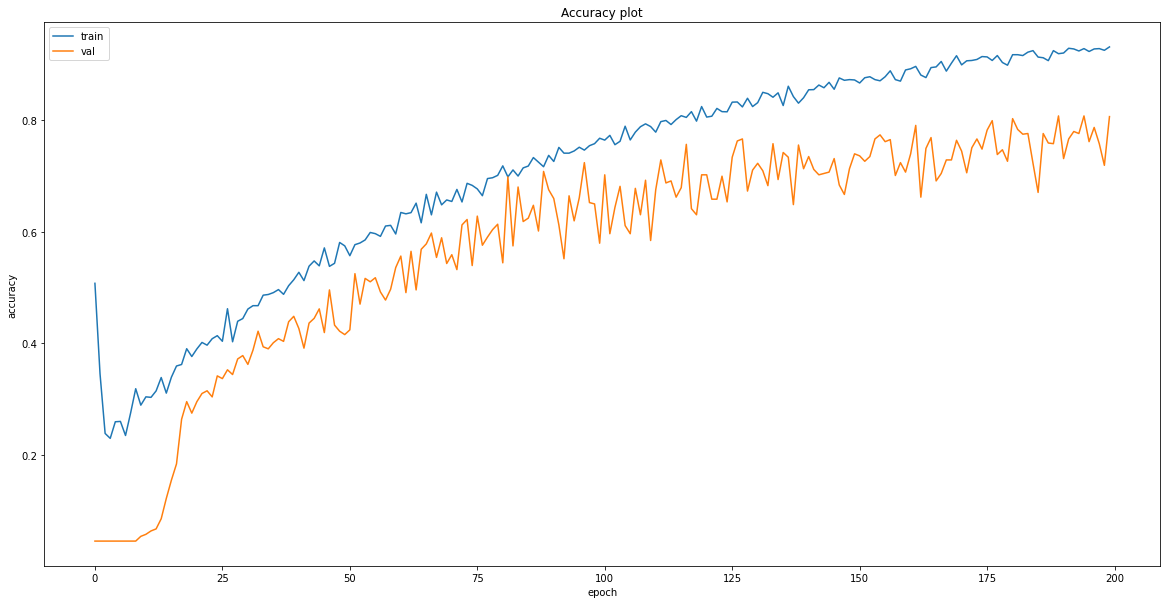

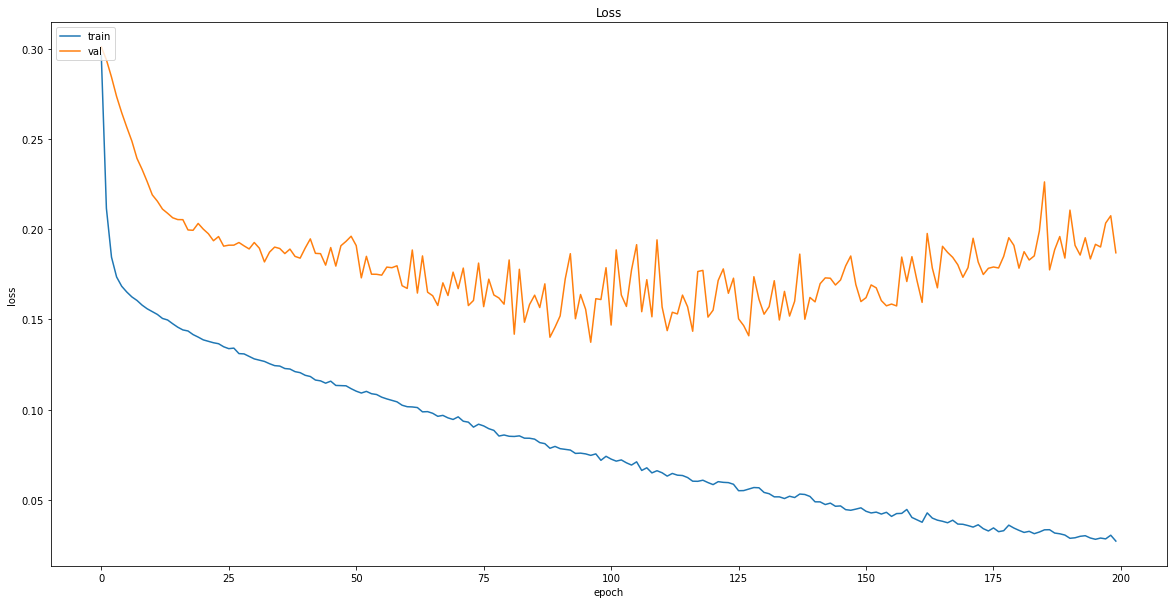

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_10.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [24]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-29   677.000000  659.619507 -24.354406  29659266.0     2.0
2019-01-30   685.000000  663.524198 -15.660616  32693525.0     2.0
2019-01-31   676.000000  665.443552 -28.553605  30423529.0     2.0
2019-02-01   689.599976  669.159925 -12.000552  34093186.0     2.0
2019-02-11   692.669983  672.776857  -8.554077  37145248.0     2.0


In [25]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [26]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(207, 10, 4)

In [27]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [28]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2094 - accuracy: 0.8068 - mean_squared_error: 10.9507 - weighted_accuracy: 0.8068 - weighted_mean_squared_error: 10.9507
Test loss: 0.2094174027442932
Test accuracy: 0.8067632913589478


In [29]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 1: 8, 0: 16})

In [30]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [31]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


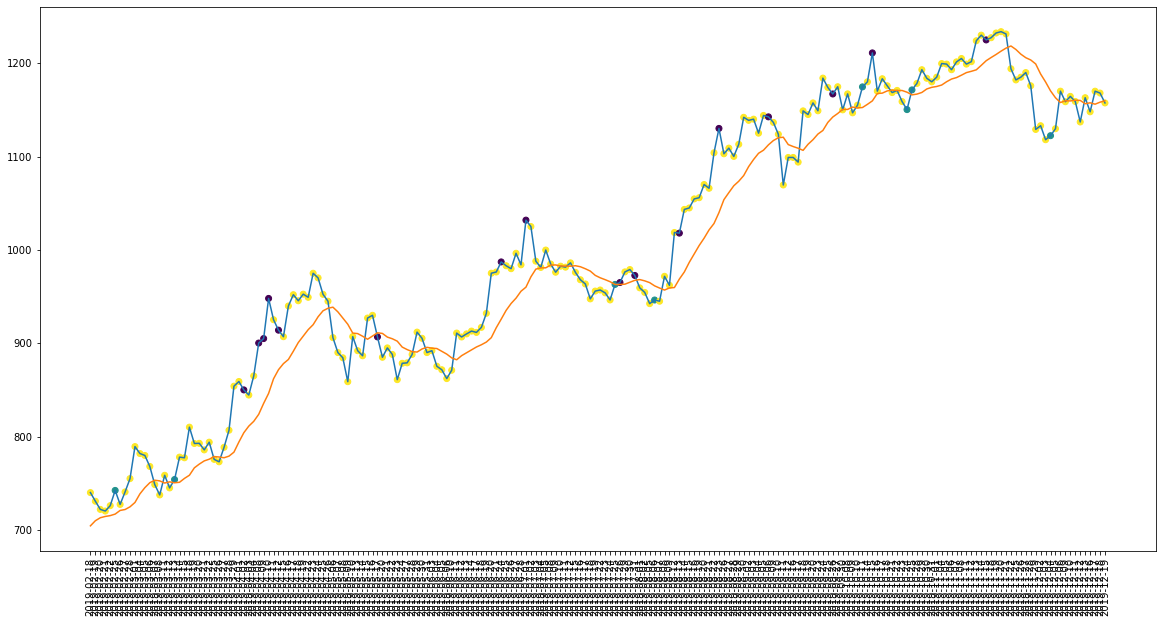

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 7
actual holds but predicted sell: 14
actual predicted holds: 164
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 88.64864864864865%
actual buys: 11
actual sells: 11
actual holds: 185


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 50.0%
Percentage sells correct: 56.25%
Percentage holds correct: 86.26373626373626%


In [35]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 50.0%
Percentage sells correct: 56.25%
Percentage holds correct: 86.26373626373626%


In [36]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $742.3300170898438
Shares owned at the moment: 13
Cash capital at the moment: $323.1714797210698


Price increase from previously bought: 14.190304983119484%
Share price: $850.0
Shares owned at the moment: 0
Cash capital at the moment: $11342.783979721069


Share price: $963.0
Shares owned at the moment: 11
Cash capital at the moment: $720.6532297210688


Price increase from previously bought: 5.416233313427665%
Share price: $1017.9500122070312
Shares owned at the moment: 0
Cash capital at the moment: $11887.31037612915


Share price: $1174.5999755859375
Shares owned at the moment: 10
Cash capital at the moment: $109.00912094116029


Stop Loss Activated!

Share price: $1129.0
Shares owned at the moment: 0
Cash capital at the moment: $11367.96162094116


Share price: $1122.3299560546877
Shares owned at the moment: 10
Cash capital at the moment: $113.79798660277811




Capital at the end of test period: $11655.969730072016
profit gained: 16.559697300720163%


In [37]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [38]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d       EMA_12   willr_14      OBV_7  labels
Date                                                              
2020-02-06   1049.98999  1066.271722 -51.486809 -1866021.0     2.0
2020-02-07   1071.00000  1066.999149 -36.923832  2851100.0     2.0
2020-02-10   1076.00000  1068.383896 -33.458108  5978971.0     2.0
2020-02-11   1066.48999  1068.092525 -38.919488  2925629.0     2.0
2020-02-12   1098.00000  1072.693675 -16.666652  7717422.0     2.0


In [39]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [40]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(208, 10, 4)

In [41]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [42]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2266 - accuracy: 0.7548 - mean_squared_error: 10.7856 - weighted_accuracy: 0.7548 - weighted_mean_squared_error: 10.7856
Test loss: 0.2265743464231491
Test accuracy: 0.754807710647583


In [43]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 0: 28, 1: 6})

In [44]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [45]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


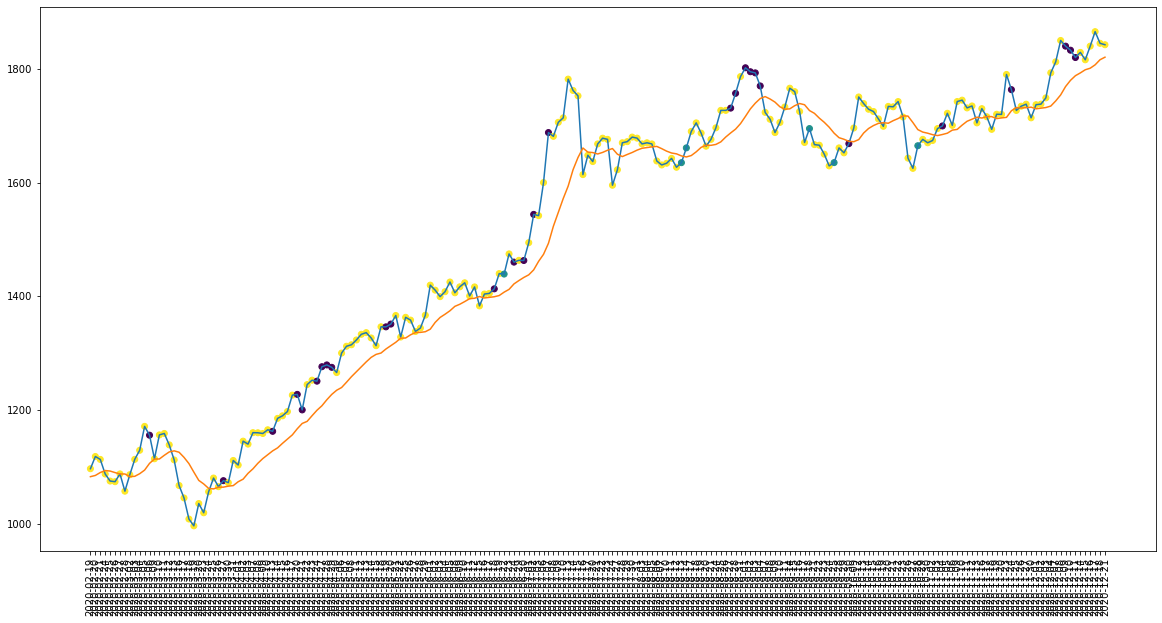

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [47]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 6
actual holds but predicted sell: 27
actual predicted holds: 156
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 82.53968253968254%
actual buys: 9
actual sells: 10
actual holds: 189


In [48]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 46.42857142857143%
Percentage holds correct: 82.65895953757226%


In [49]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1439.0
Shares owned at the moment: 6
Cash capital at the moment: $1342.2564999999995


Price increase from previously bought: 7.002477031110943%
Share price: $1544.0
Shares owned at the moment: 0
Cash capital at the moment: $10580.780499999999


Share price: $1635.0
Shares owned at the moment: 6
Cash capital at the moment: $743.8029999999981


Price increase from previously bought: 5.581211301947153%
Share price: $1731.0
Shares owned at the moment: 0
Cash capital at the moment: $11101.241499999998


Share price: $1695.0
Shares owned at the moment: 6
Cash capital at the moment: $903.2739999999976


Stop Loss Activated!

Share price: $1629.3199462890625
Shares owned at the moment: 0
Cash capital at the moment: $10652.309898620602


Share price: $1635.1099853515625
Shares owned at the moment: 6
Cash capital at the moment: $814.6706717529269


Price increase from previously bought: 7.556292276932908%
Share price: $1763.5
Shares owned at the moment: 0
Cash capital at the momen

In [50]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [51]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [52]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [53]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [54]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(1258, 10, 4)

In [55]:
y = labels
y = np.array(y)

In [56]:
X[0]

array([[1.23455155e-02, 9.84385215e-04, 1.71855875e-01, 1.39018632e-01],
       [0.00000000e+00, 0.00000000e+00, 3.95996941e-02, 0.00000000e+00],
       [2.88065462e-01, 8.70327109e-02, 4.30257207e-01, 2.60903658e-01],
       [6.66666667e-01, 2.76156615e-01, 9.42184674e-01, 6.00543654e-01],
       [5.78189123e-01, 4.09197136e-01, 6.62057806e-01, 3.94876421e-01],
       [3.04525904e-01, 4.38297201e-01, 0.00000000e+00, 1.76333261e-01],
       [5.94649565e-01, 5.51413777e-01, 2.44003374e-01, 4.82238834e-01],
       [6.35802510e-01, 6.59680263e-01, 3.19268990e-01, 7.38451605e-01],
       [1.00000000e+00, 8.62377790e-01, 1.00000000e+00, 1.00000000e+00],
       [8.88888889e-01, 1.00000000e+00, 7.30921769e-01, 7.58335204e-01]])

In [57]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [58]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [59]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [61]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 91ms/step - loss: 0.3412 - accuracy: 0.5249 - mse: 0.3691 - weighted_accuracy: 0.3073 - weighted_mse: 0.4651 - val_loss: 0.3035 - val_accuracy: 0.0476 - val_mse: 0.3398 - val_weighted_accuracy: 0.0476 - val_weighted_mse: 0.3398
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2789 - accuracy: 0.4930 - mse: 0.4286 - weighted_accuracy: 0.4053 - weighted_mse: 0.4736 - val_loss: 0.3031 - val_accuracy: 0.0397 - val_mse: 0.3442 - val_weighted_accuracy: 0.0397 - val_weighted_mse: 0.3442
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2451 - accuracy: 0.4513 - mse: 0.5070 - weighted_accuracy: 0.4758 - weighted_mse: 0.5224 - val_loss: 0.3014 - val_accuracy: 0.0476 - val_mse: 0.3467 - val_weighted_accuracy: 0.0476 - val_weighted_mse: 0.3467
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2210 - accuracy: 0.4274 - mse: 0.5839 - weighted_accuracy: 0.5200 - weighted_mse: 0

8/8 [==============================] - 0s 7ms/step - loss: 0.1279 - accuracy: 0.5199 - mse: 1.3752 - weighted_accuracy: 0.7671 - weighted_mse: 1.3294 - val_loss: 0.2318 - val_accuracy: 0.0437 - val_mse: 0.7436 - val_weighted_accuracy: 0.0437 - val_weighted_mse: 0.7436
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1272 - accuracy: 0.5308 - mse: 1.3827 - weighted_accuracy: 0.7837 - weighted_mse: 1.3607 - val_loss: 0.2299 - val_accuracy: 0.0437 - val_mse: 0.7651 - val_weighted_accuracy: 0.0437 - val_weighted_mse: 0.7651
Epoch 32/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.5437 - mse: 1.3910 - weighted_accuracy: 0.7847 - weighted_mse: 1.3578 - val_loss: 0.2277 - val_accuracy: 0.0437 - val_mse: 0.7833 - val_weighted_accuracy: 0.0437 - val_weighted_mse: 0.7833
Epoch 33/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1243 - accuracy: 0.5378 - mse: 1.4048 - weighted_accuracy: 0.7964 - weighted_mse: 1.3660 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0973 - accuracy: 0.6779 - mse: 1.6935 - weighted_accuracy: 0.8818 - weighted_mse: 1.7041 - val_loss: 0.1728 - val_accuracy: 0.5238 - val_mse: 1.1979 - val_weighted_accuracy: 0.5238 - val_weighted_mse: 1.1979
Epoch 60/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0958 - accuracy: 0.6680 - mse: 1.7087 - weighted_accuracy: 0.8782 - weighted_mse: 1.7311 - val_loss: 0.1743 - val_accuracy: 0.5119 - val_mse: 1.2293 - val_weighted_accuracy: 0.5119 - val_weighted_mse: 1.2293
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0939 - accuracy: 0.6839 - mse: 1.7163 - weighted_accuracy: 0.8840 - weighted_mse: 1.7585 - val_loss: 0.1684 - val_accuracy: 0.5516 - val_mse: 1.2237 - val_weighted_accuracy: 0.5516 - val_weighted_mse: 1.2237
Epoch 62/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.6928 - mse: 1.7219 - weighted_accuracy: 0.8873 - weighted_mse: 1.7464 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.7654 - mse: 2.1892 - weighted_accuracy: 0.9139 - weighted_mse: 2.2873 - val_loss: 0.1650 - val_accuracy: 0.5794 - val_mse: 2.0128 - val_weighted_accuracy: 0.5794 - val_weighted_mse: 2.0128
Epoch 89/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.7883 - mse: 2.1767 - weighted_accuracy: 0.9223 - weighted_mse: 2.2408 - val_loss: 0.1538 - val_accuracy: 0.6468 - val_mse: 1.9957 - val_weighted_accuracy: 0.6468 - val_weighted_mse: 1.9957
Epoch 90/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0703 - accuracy: 0.8201 - mse: 2.1840 - weighted_accuracy: 0.9277 - weighted_mse: 2.2439 - val_loss: 0.1630 - val_accuracy: 0.5992 - val_mse: 2.0487 - val_weighted_accuracy: 0.5992 - val_weighted_mse: 2.0487
Epoch 91/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0704 - accuracy: 0.8032 - mse: 2.2021 - weighted_accuracy: 0.9278 - weighted_mse: 2.2747 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0527 - accuracy: 0.8559 - mse: 2.7745 - weighted_accuracy: 0.9471 - weighted_mse: 2.8123 - val_loss: 0.1754 - val_accuracy: 0.6429 - val_mse: 3.0300 - val_weighted_accuracy: 0.6429 - val_weighted_mse: 3.0300
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.8569 - mse: 2.8114 - weighted_accuracy: 0.9475 - weighted_mse: 2.8587 - val_loss: 0.1682 - val_accuracy: 0.6825 - val_mse: 3.0246 - val_weighted_accuracy: 0.6825 - val_weighted_mse: 3.0246
Epoch 119/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.8678 - mse: 2.8079 - weighted_accuracy: 0.9515 - weighted_mse: 2.8538 - val_loss: 0.1651 - val_accuracy: 0.6984 - val_mse: 3.0590 - val_weighted_accuracy: 0.6984 - val_weighted_mse: 3.0590
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.8718 - mse: 2.8431 - weighted_accuracy: 0.9530 - weighted_mse: 2.8611 -

Epoch 146/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9036 - mse: 3.6676 - weighted_accuracy: 0.9646 - weighted_mse: 3.5994 - val_loss: 0.1724 - val_accuracy: 0.7183 - val_mse: 4.0953 - val_weighted_accuracy: 0.7183 - val_weighted_mse: 4.0953
Epoch 147/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9036 - mse: 3.6788 - weighted_accuracy: 0.9646 - weighted_mse: 3.6072 - val_loss: 0.1744 - val_accuracy: 0.7103 - val_mse: 4.1011 - val_weighted_accuracy: 0.7103 - val_weighted_mse: 4.1011
Epoch 148/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0363 - accuracy: 0.9076 - mse: 3.7063 - weighted_accuracy: 0.9661 - weighted_mse: 3.6021 - val_loss: 0.1778 - val_accuracy: 0.6944 - val_mse: 4.0581 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 4.0581
Epoch 149/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.9036 - mse: 3.7605 - weighted_accuracy: 0.9646 - weighted

Epoch 175/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9453 - mse: 4.8312 - weighted_accuracy: 0.9799 - weighted_mse: 4.3494 - val_loss: 0.1880 - val_accuracy: 0.7381 - val_mse: 5.2137 - val_weighted_accuracy: 0.7381 - val_weighted_mse: 5.2137
Epoch 176/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9463 - mse: 4.8802 - weighted_accuracy: 0.9803 - weighted_mse: 4.4406 - val_loss: 0.1928 - val_accuracy: 0.7183 - val_mse: 5.1556 - val_weighted_accuracy: 0.7183 - val_weighted_mse: 5.1556
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9284 - mse: 4.9028 - weighted_accuracy: 0.9737 - weighted_mse: 4.5299 - val_loss: 0.1810 - val_accuracy: 0.7540 - val_mse: 5.3647 - val_weighted_accuracy: 0.7540 - val_weighted_mse: 5.3647
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9414 - mse: 4.9910 - weighted_accuracy: 0.9785 - weighted

In [62]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19493168592453003
Test accuracy: 0.7777777910232544


In [63]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.44546390e-01 -4.12860775e+00 -3.87996435e-02]
 [-1.36832011e+00 -3.91283536e+00  1.78642797e+00]
 [-3.68126535e+00 -1.46543527e+00  1.43015516e+00]
 [-3.09427261e+00 -2.12233853e+00  1.71371257e+00]
 [-1.96102858e-01 -3.30409861e+00 -2.09308416e-01]
 [-2.77620125e+00 -2.65967441e+00  1.57158947e+00]
 [-3.10952950e+00 -1.45612669e+00  1.14884269e+00]
 [-3.79946089e+00  1.61456561e+00 -1.74977708e+00]
 [-1.54660451e+00 -1.87516165e+00 -3.64703715e-01]
 [-3.95162153e+00 -6.87029004e-01  3.30891013e-02]
 [-3.11863184e+00 -1.64280248e+00  2.03797507e+00]
 [-3.51251173e+00 -2.70111346e+00  2.09126306e+00]
 [-1.75729716e+00 -2.18119836e+00  7.64465272e-01]
 [-2.74804688e+00 -1.93009329e+00  1.30203342e+00]
 [-2.31843090e+00 -3.43941188e+00  1.71831679e+00]
 [-6.38483822e-01 -2.54702353e+00 -1.05250806e-01]
 [-5.33400059e+00 -2.59636760e+00  1.22767019e+00]
 [-2.16538048e+00 -2.15216875e+00  1.73429036e+00]
 [-3.72107887e+00 -2.08143616e+00  2.60244060e+00]
 [-3.21174908e+00 -2.79899454e+

Counter({2: 216, 0: 17, 1: 19})

In [64]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 229, 1: 12, 0: 11})

In [65]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 252
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 18
actual holds but predicted sell: 16
actual predicted holds: 195
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 85.1528384279476%
actual buys: 12
actual sells: 11
actual holds: 229


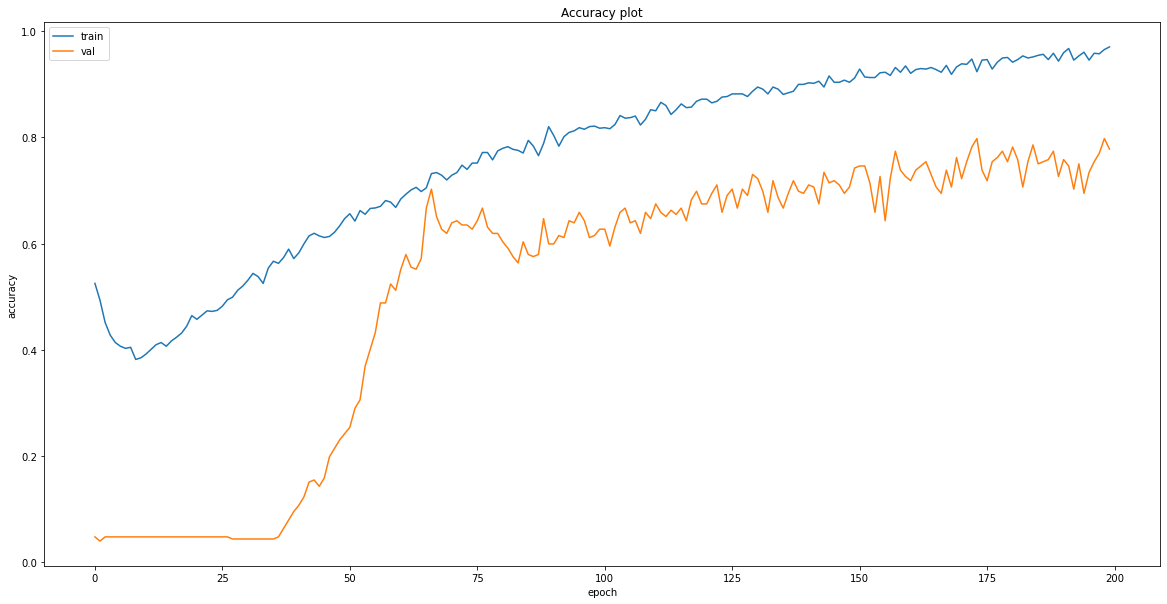

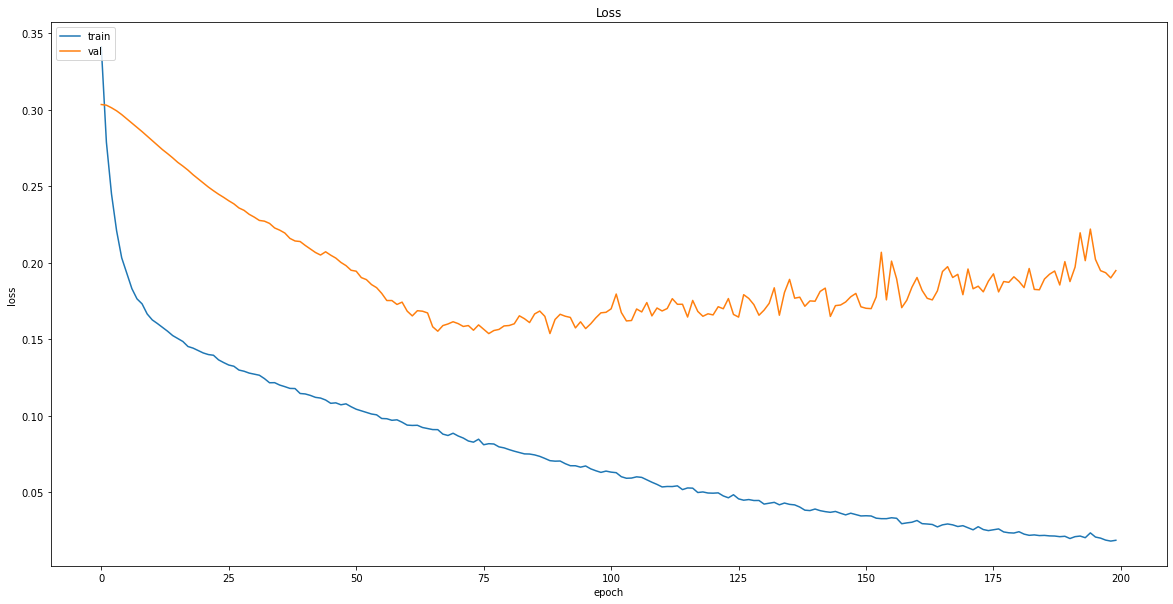

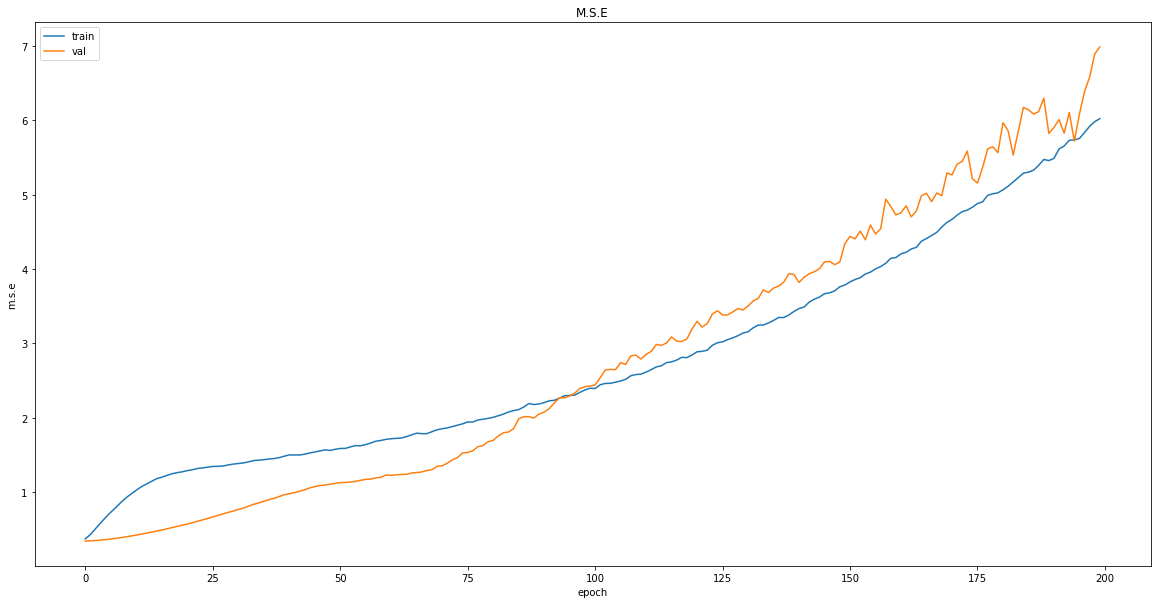

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [68]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-29    41.840000  40.791393 -22.393818  268032095.0     2.0
2019-01-30    43.000000  41.131179  -0.000000  305001247.0     2.0
2019-01-31    42.099998  41.280228 -21.686776  275782105.0     2.0
2019-02-01    43.529999  41.626347  -1.635507  314703641.0     2.0
2019-02-11    44.259998  42.031524  -4.642200  345923962.0     2.0


In [69]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [70]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(207, 10, 4)

In [71]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [72]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1750 - accuracy: 0.8454 - mean_squared_error: 7.8540 - weighted_accuracy: 0.8454 - weighted_mean_squared_error: 7.8540
Test loss: 0.17497266829013824
Test accuracy: 0.8454106450080872


In [73]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 194, 1: 7, 0: 6})

In [74]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [75]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


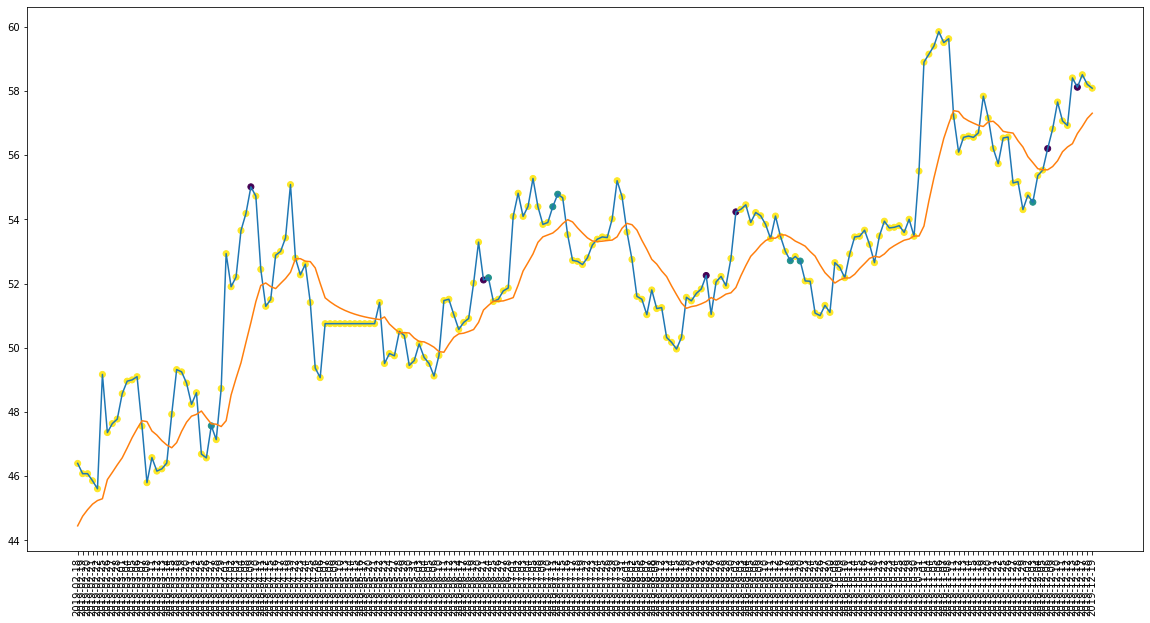

In [76]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

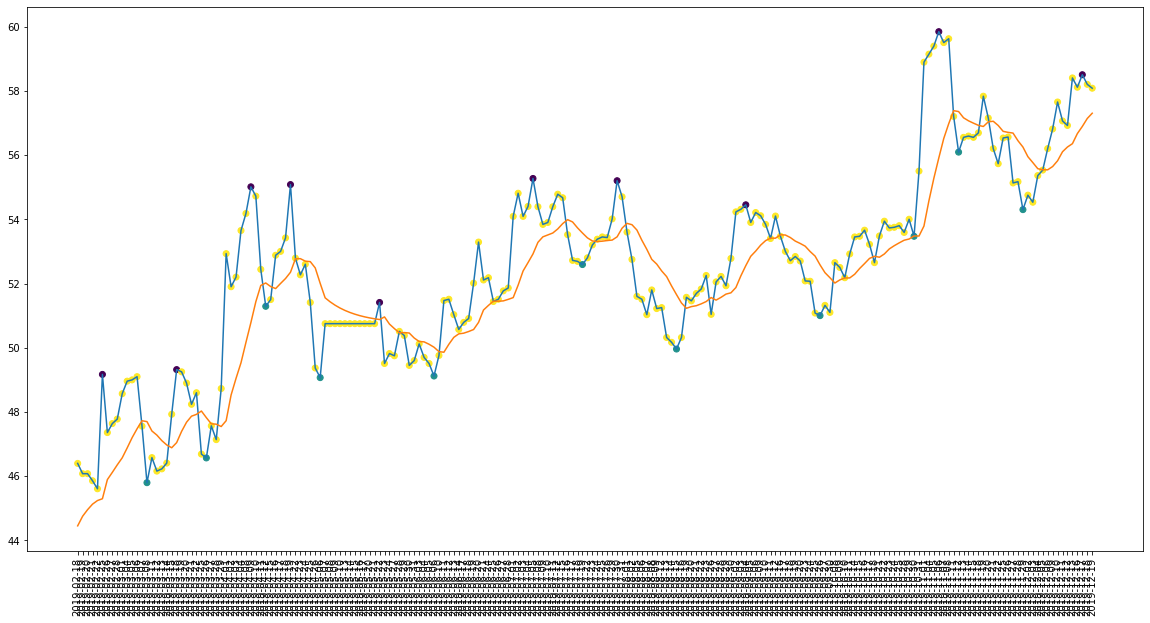

In [77]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [78]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 7
actual holds but predicted sell: 5
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 93.54838709677419%
actual buys: 11
actual sells: 10
actual holds: 186


In [79]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 83.33333333333333%
Percentage holds correct: 79.79274611398964%


In [80]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $47.56999969482422
Shares owned at the moment: 209
Cash capital at the moment: $30.52920645713857


Price increase from previously bought: 15.32296836304492%
Share price: $55.0099983215332
Shares owned at the moment: 0
Cash capital at the moment: $11496.001859122276


Share price: $52.18000030517578
Shares owned at the moment: 219
Cash capital at the moment: $37.156387104987516


Stop Loss Activated!

Share price: $50.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11026.931100455284


Share price: $52.709999084472656
Shares owned at the moment: 208
Cash capital at the moment: $33.10117140865259


Stop Loss Activated!

Share price: $51.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $10628.523791220665


Share price: $54.52999877929688
Shares owned at the moment: 194
Cash capital at the moment: $20.612273688313508


Price increase from previously bought: 6.272946373808441%
Share price: $58.11000061035156
Shares owned at th

In [81]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### recession

In [82]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df = df.iloc[5:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-06    52.869999  55.859049 -71.253297 -22831883.0     2.0
2020-02-07    53.790001  55.540734 -63.190177  16534916.0     2.0
2020-02-10    52.830002  55.123698 -71.603841 -17874085.0     2.0
2020-02-11    52.299999  54.689283 -76.248912 -52478854.0     2.0
2020-02-12    54.680000  54.687855 -55.390007  -3090621.0     0.0


In [83]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [84]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(208, 10, 4)

In [85]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [86]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.8558 - mean_squared_error: 6.3067 - weighted_accuracy: 0.8558 - weighted_mean_squared_error: 6.3067
Test loss: 0.13474908471107483
Test accuracy: 0.8557692170143127


In [87]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 11, 1: 7})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [89]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


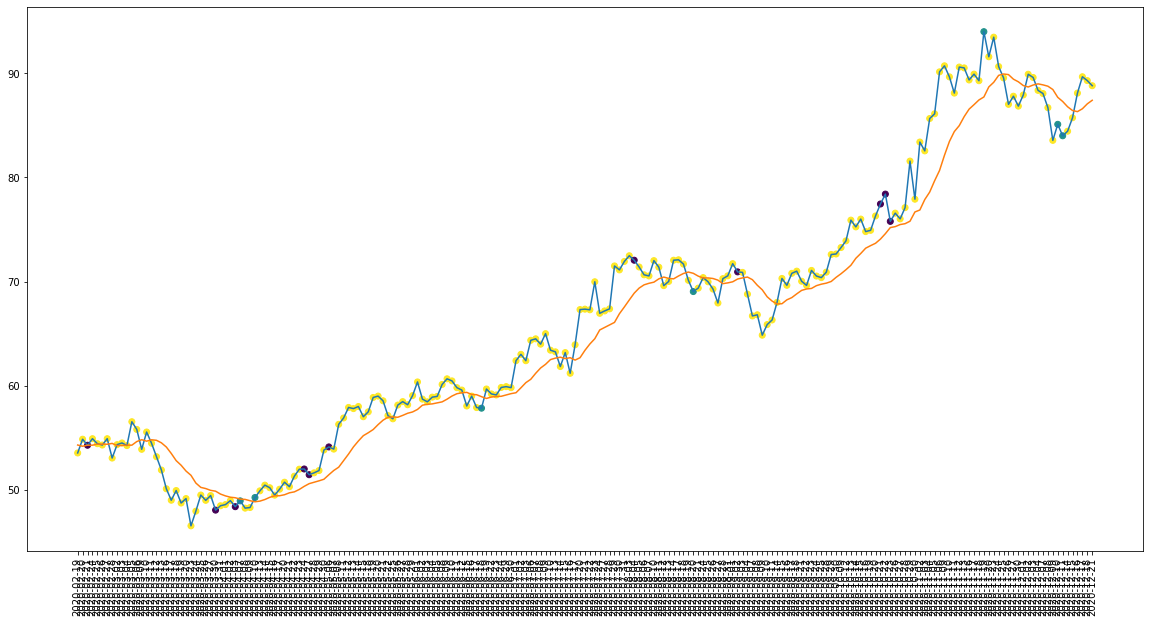

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

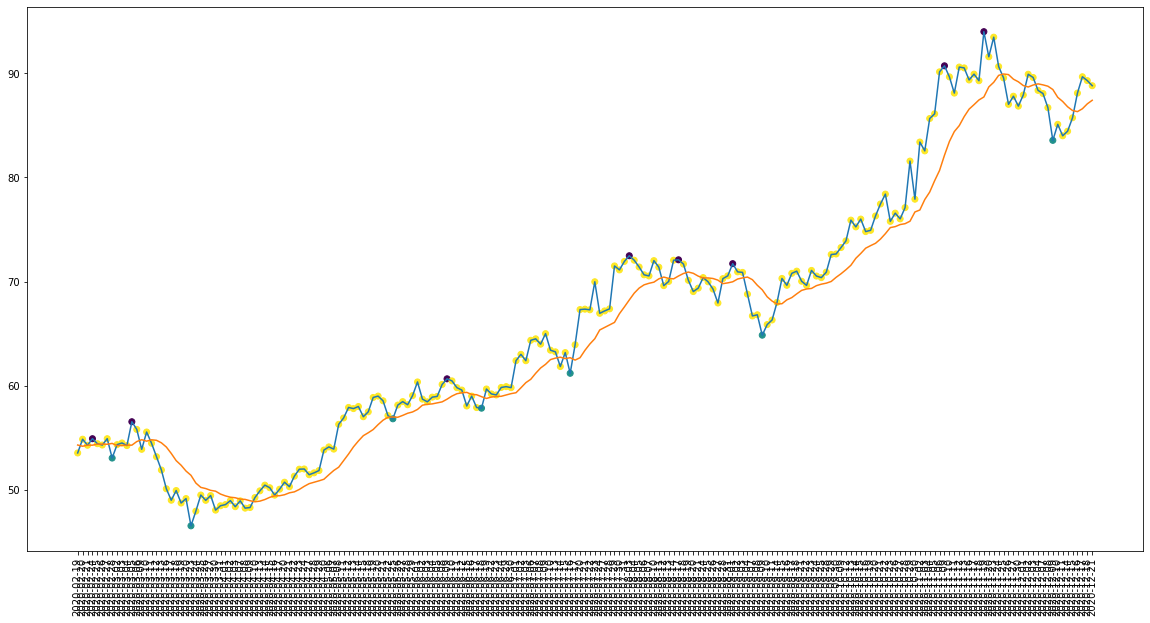

In [91]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [92]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 5
actual holds but predicted sell: 11
actual predicted holds: 177
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 91.70984455958549%
actual buys: 7
actual sells: 8
actual holds: 193


In [93]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 86.24338624338624%


In [94]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $48.93999862670898
Shares owned at the moment: 203
Cash capital at the moment: $37.859524544717715


Price increase from previously bought: 5.961163928654356%
Share price: $52.0
Shares owned at the moment: 0
Cash capital at the moment: $10564.830524544717


Share price: $57.84000015258789
Shares owned at the moment: 182
Cash capital at the moment: $9.001576697350174


Price increase from previously bought: 24.226156185432068%
Share price: $72.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $13086.041105589868


Share price: $69.04000091552734
Shares owned at the moment: 189
Cash capital at the moment: $1.5973920793530851


Stop Loss Activated!

Share price: $66.69999694824219
Shares owned at the moment: 0
Cash capital at the moment: $12573.229491883278


Share price: $94.0
Shares owned at the moment: 133
Cash capital at the moment: $36.84899188327654


Stop Loss Activated!

Share price: $90.6500015258789
Shares owned at the moment: 0
Cash capital a

In [95]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [96]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


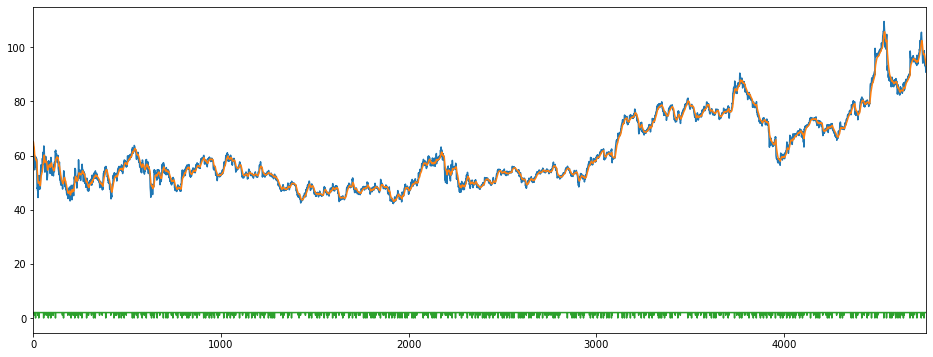

In [97]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [98]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [99]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1

In [100]:
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
X.shape

(4750, 10, 4)

In [101]:
y = labels
y = np.array(y)

In [102]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [103]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [104]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [106]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2865 - accuracy: 0.4576 - mse: 0.4790 - weighted_accuracy: 0.3356 - weighted_mse: 0.5253 - val_loss: 0.3001 - val_accuracy: 0.0453 - val_mse: 0.3520 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3520
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2054 - accuracy: 0.3103 - mse: 0.8185 - weighted_accuracy: 0.4945 - weighted_mse: 0.7699 - val_loss: 0.2912 - val_accuracy: 0.0453 - val_mse: 0.3837 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3837
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1839 - accuracy: 0.2708 - mse: 1.0685 - weighted_accuracy: 0.5180 - weighted_mse: 1.0153 - val_loss: 0.2798 - val_accuracy: 0.0453 - val_mse: 0.4225 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4225
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1767 - accuracy: 0.2547 - mse: 1.2282 - weighted_accuracy: 0.5318 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1332 - accuracy: 0.4237 - mse: 1.7837 - weighted_accuracy: 0.7345 - weighted_mse: 1.7164 - val_loss: 0.1961 - val_accuracy: 0.3032 - val_mse: 1.7959 - val_weighted_accuracy: 0.3032 - val_weighted_mse: 1.7959
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1315 - accuracy: 0.4129 - mse: 1.8068 - weighted_accuracy: 0.7375 - weighted_mse: 1.7360 - val_loss: 0.1848 - val_accuracy: 0.3937 - val_mse: 1.7887 - val_weighted_accuracy: 0.3937 - val_weighted_mse: 1.7887
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1308 - accuracy: 0.4555 - mse: 1.8101 - weighted_accuracy: 0.7408 - weighted_mse: 1.7549 - val_loss: 0.1946 - val_accuracy: 0.3400 - val_mse: 1.8120 - val_weighted_accuracy: 0.3400 - val_weighted_mse: 1.8120
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.4374 - mse: 1.8164 - weighted_accuracy: 0.7450 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1065 - accuracy: 0.6039 - mse: 2.3430 - weighted_accuracy: 0.8239 - weighted_mse: 2.3576 - val_loss: 0.1704 - val_accuracy: 0.5137 - val_mse: 2.3118 - val_weighted_accuracy: 0.5137 - val_weighted_mse: 2.3118
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1064 - accuracy: 0.6071 - mse: 2.3590 - weighted_accuracy: 0.8252 - weighted_mse: 2.3682 - val_loss: 0.1893 - val_accuracy: 0.4284 - val_mse: 2.2782 - val_weighted_accuracy: 0.4284 - val_weighted_mse: 2.2782
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1042 - accuracy: 0.6047 - mse: 2.3646 - weighted_accuracy: 0.8316 - weighted_mse: 2.3733 - val_loss: 0.1635 - val_accuracy: 0.5632 - val_mse: 2.3059 - val_weighted_accuracy: 0.5632 - val_weighted_mse: 2.3059
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1058 - accuracy: 0.6076 - mse: 2.4043 - weighted_accuracy: 0.8182 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0845 - accuracy: 0.7174 - mse: 3.2085 - weighted_accuracy: 0.8765 - weighted_mse: 3.2382 - val_loss: 0.1514 - val_accuracy: 0.6453 - val_mse: 3.3181 - val_weighted_accuracy: 0.6453 - val_weighted_mse: 3.3181
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0826 - accuracy: 0.7187 - mse: 3.1982 - weighted_accuracy: 0.8859 - weighted_mse: 3.2134 - val_loss: 0.1443 - val_accuracy: 0.7011 - val_mse: 3.1962 - val_weighted_accuracy: 0.7011 - val_weighted_mse: 3.1962
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.7239 - mse: 3.2021 - weighted_accuracy: 0.8861 - weighted_mse: 3.2232 - val_loss: 0.1684 - val_accuracy: 0.6084 - val_mse: 3.2524 - val_weighted_accuracy: 0.6084 - val_weighted_mse: 3.2524
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0814 - accuracy: 0.7326 - mse: 3.2217 - weighted_accuracy: 0.8801 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0627 - accuracy: 0.7913 - mse: 4.3029 - weighted_accuracy: 0.9179 - weighted_mse: 4.2514 - val_loss: 0.1490 - val_accuracy: 0.7611 - val_mse: 4.6747 - val_weighted_accuracy: 0.7611 - val_weighted_mse: 4.6747
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0629 - accuracy: 0.8055 - mse: 4.3706 - weighted_accuracy: 0.9250 - weighted_mse: 4.3103 - val_loss: 0.1656 - val_accuracy: 0.6958 - val_mse: 4.5389 - val_weighted_accuracy: 0.6958 - val_weighted_mse: 4.5389
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0625 - accuracy: 0.8166 - mse: 4.3533 - weighted_accuracy: 0.9272 - weighted_mse: 4.3160 - val_loss: 0.1937 - val_accuracy: 0.5874 - val_mse: 4.4388 - val_weighted_accuracy: 0.5874 - val_weighted_mse: 4.4388
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0615 - accuracy: 0.8029 - mse: 4.4036 - weighted_accuracy: 0.9167 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 0.8661 - mse: 5.9120 - weighted_accuracy: 0.9490 - weighted_mse: 5.5698 - val_loss: 0.1841 - val_accuracy: 0.7295 - val_mse: 6.1055 - val_weighted_accuracy: 0.7295 - val_weighted_mse: 6.1055
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.8676 - mse: 5.8733 - weighted_accuracy: 0.9459 - weighted_mse: 5.5538 - val_loss: 0.1829 - val_accuracy: 0.7084 - val_mse: 6.0039 - val_weighted_accuracy: 0.7084 - val_weighted_mse: 6.0039
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.8742 - mse: 5.9411 - weighted_accuracy: 0.9502 - weighted_mse: 5.6003 - val_loss: 0.1817 - val_accuracy: 0.7105 - val_mse: 5.9869 - val_weighted_accuracy: 0.7105 - val_weighted_mse: 5.9869
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.8755 - mse: 6.0087 - weighted_accuracy: 0.9470 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.8921 - mse: 7.7328 - weighted_accuracy: 0.9549 - weighted_mse: 7.0699 - val_loss: 0.2021 - val_accuracy: 0.7242 - val_mse: 7.5587 - val_weighted_accuracy: 0.7242 - val_weighted_mse: 7.5587
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.8997 - mse: 7.9182 - weighted_accuracy: 0.9596 - weighted_mse: 7.2212 - val_loss: 0.1974 - val_accuracy: 0.7789 - val_mse: 8.0656 - val_weighted_accuracy: 0.7789 - val_weighted_mse: 8.0656
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9037 - mse: 7.8751 - weighted_accuracy: 0.9646 - weighted_mse: 7.1487 - val_loss: 0.2001 - val_accuracy: 0.7621 - val_mse: 8.0249 - val_weighted_accuracy: 0.7621 - val_weighted_mse: 8.0249
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0332 - accuracy: 0.9108 - mse: 8.0044 - weighted_accuracy: 0.9654 - 

In [107]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22307509183883667
Test accuracy: 0.7515789270401001


In [108]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.071324   -5.5074577   0.67550755]
 [-5.756748    1.0828362  -1.5838263 ]
 [ 0.7367817  -1.0567893  -1.9818522 ]
 ...
 [-1.9783111  -3.5034242   1.7989163 ]
 [-5.838638   -1.0119927   0.02920484]
 [-2.5826929  -4.1107492   1.780432  ]]


Counter({2: 781, 1: 69, 0: 100})

In [109]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 44, 1: 43})

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 39
actual holds but predicted buy: 63
actual holds but predicted sell: 95
actual predicted holds: 705
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 81.6917728852839%
actual buys: 43
actual sells: 44
actual holds: 863


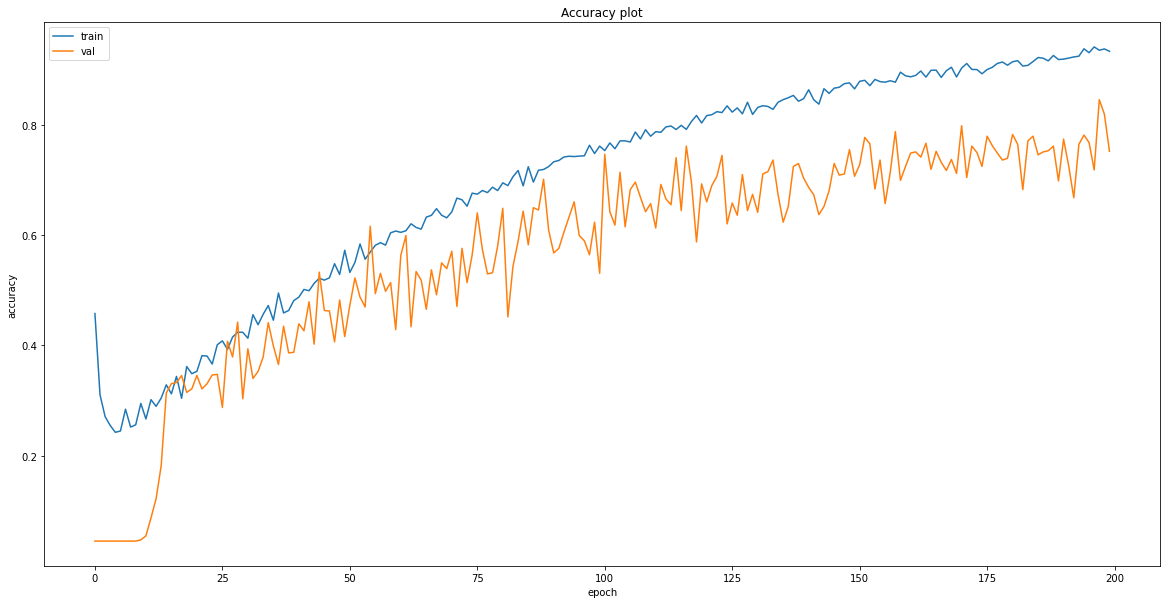

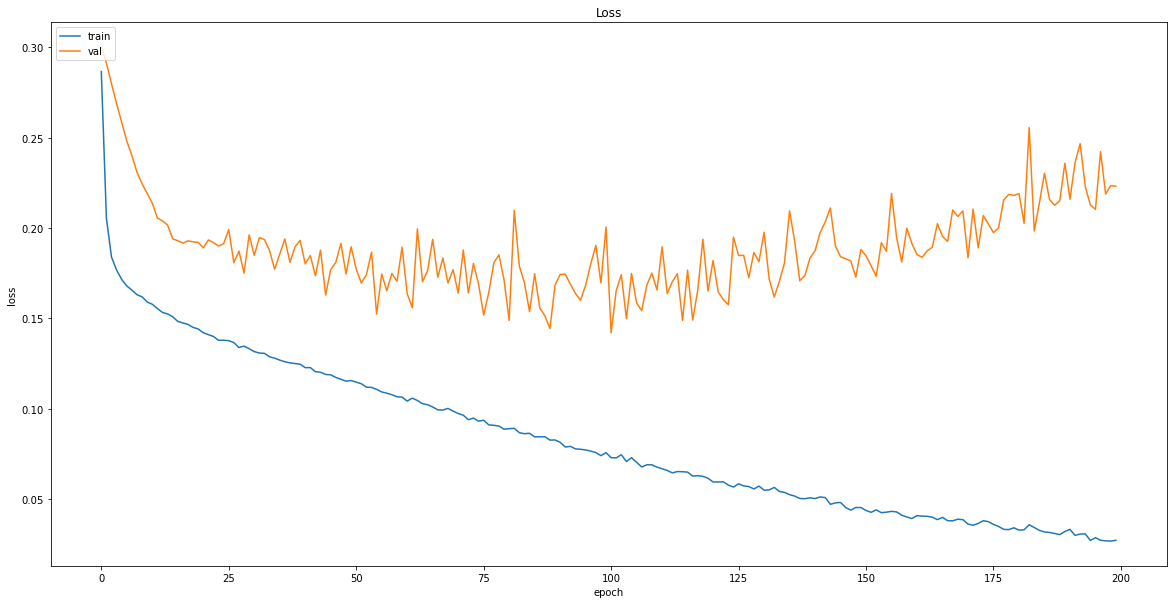

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [112]:
# Save model
model.save("models/{}".format('wmt_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [113]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,97.059998,96.626808,-36.757664,50249200.0,2.0
2019-01-30,96.709999,96.639606,-42.375621,44995800.0,2.0
2019-01-31,94.800003,96.356591,-73.033684,33146500.0,2.0
2019-02-01,95.830002,96.275577,-69.155190,47869500.0,1.0
2019-02-04,93.860001,95.903950,-87.980765,35277600.0,2.0


In [114]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [115]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [116]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.7615 - mean_squared_error: 10.0566 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 10.0566
Test loss: 0.23280952870845795
Test accuracy: 0.7614678740501404


In [117]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 0: 32, 1: 11})

In [118]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [119]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


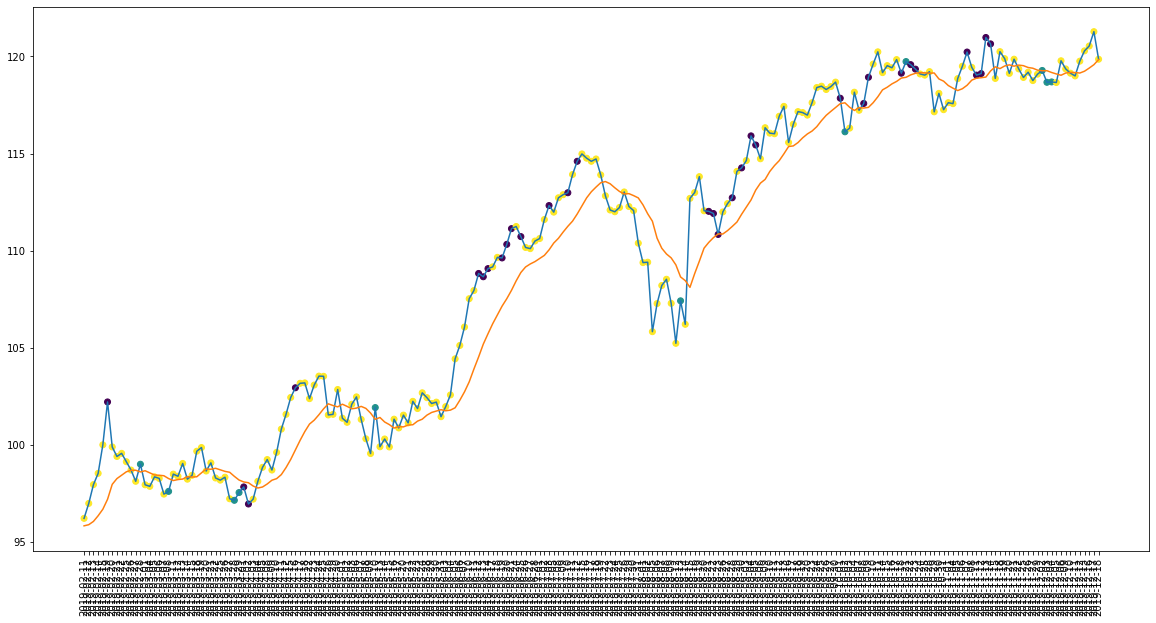

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

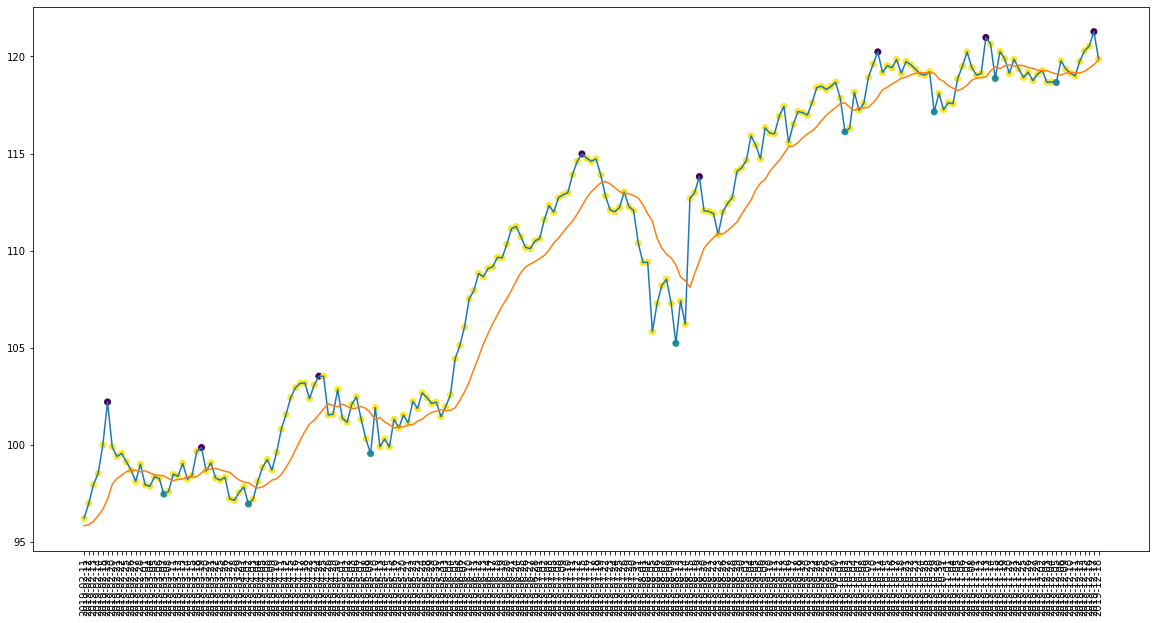

In [121]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [122]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 10
actual holds but predicted sell: 29
actual predicted holds: 163
Percentage buys correct: 12.5%
Percentage sells correct: 25.0%
Percentage holds correct: 80.6930693069307%
actual buys: 8
actual sells: 8
actual holds: 202


In [123]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 46.875%
Percentage holds correct: 85.05747126436782%


In [124]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.98999786376952
Shares owned at the moment: 100
Cash capital at the moment: $73.77796421051244


Price increase from previously bought: 9.62881880182438%
Share price: $108.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10925.852433776858


Share price: $107.41000366210938
Shares owned at the moment: 101
Cash capital at the moment: $47.60893538665914


Price increase from previously bought: 6.08569496966167%
Share price: $114.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $11556.1334355526


Share price: $116.12000274658205
Shares owned at the moment: 99
Cash capital at the moment: $28.63949289321863




Capital at the end of test period: $11862.147668151854
profit gained: 18.62147668151854%


In [125]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [126]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,116.599998,116.083829,-16.417993,-9158300.0,2.0
2020-01-30,115.889999,116.054009,-31.556558,-12933800.0,2.0
2020-01-31,116.580002,116.134931,-16.308909,-8352300.0,2.0
2020-02-03,114.489998,115.881864,-59.234312,-16128100.0,1.0
2020-02-04,114.269997,115.633884,-64.189291,-20480000.0,2.0


In [127]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(219, 10, 4)

In [128]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [129]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1882 - accuracy: 0.7854 - mean_squared_error: 9.4334 - weighted_accuracy: 0.7854 - weighted_mean_squared_error: 9.4334
Test loss: 0.18816950917243958
Test accuracy: 0.7853881120681763


In [130]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 23, 1: 6})

In [131]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [132]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


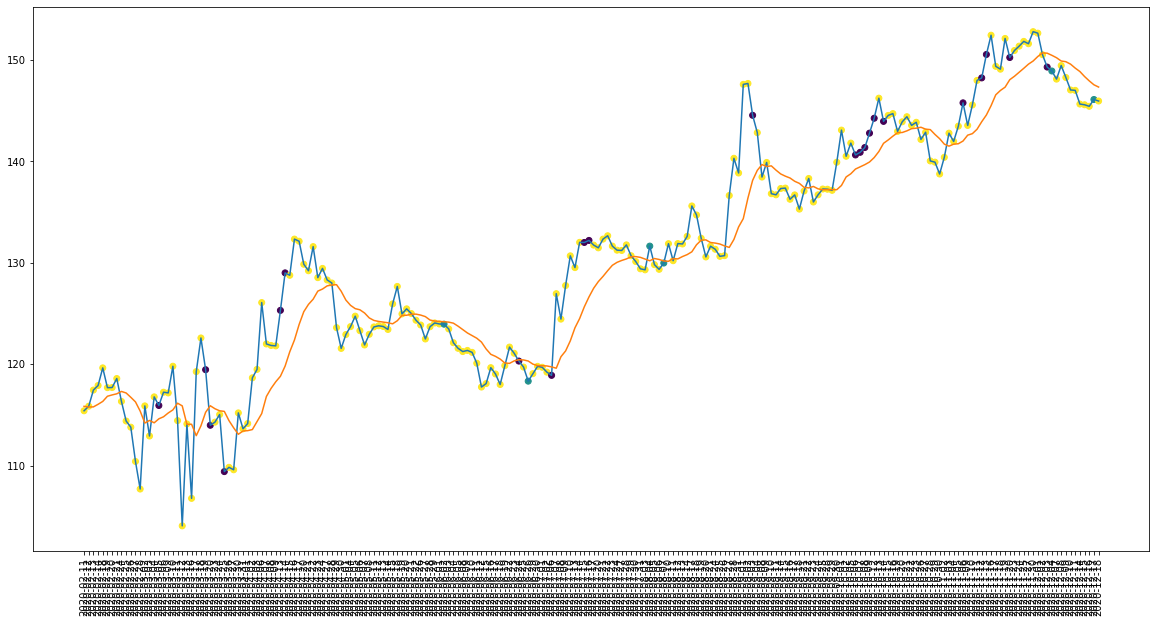

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

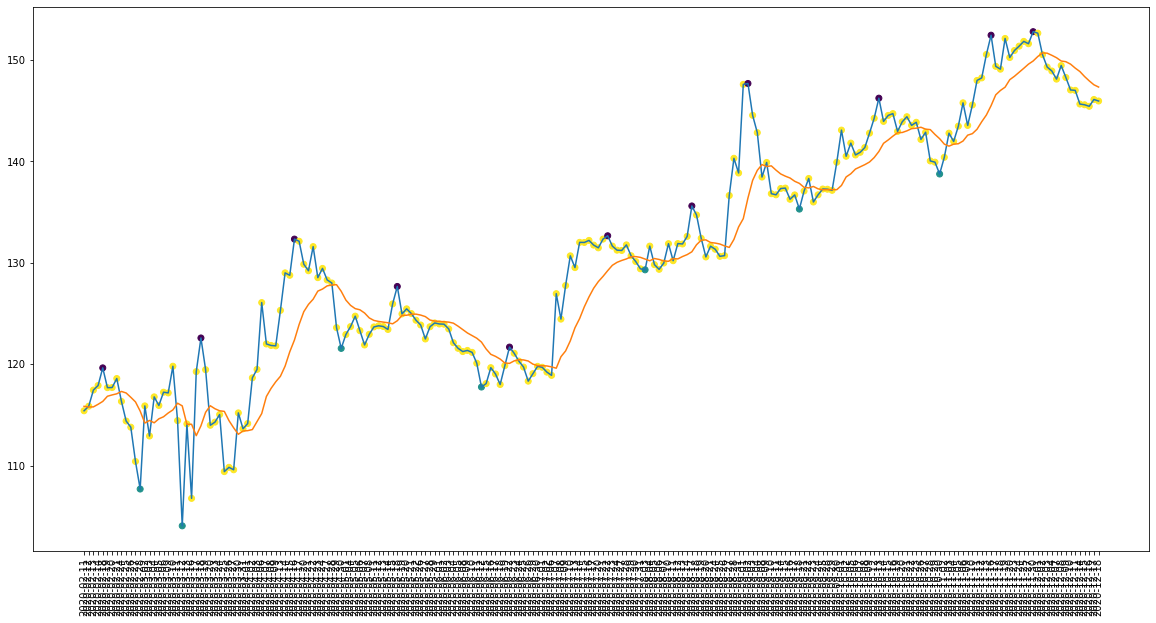

In [134]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [135]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 6
actual holds but predicted sell: 23
actual predicted holds: 172
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 85.57213930348259%
actual buys: 7
actual sells: 11
actual holds: 201


In [136]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 50.0%
Percentage sells correct: 40.90909090909091%
Percentage holds correct: 84.73684210526316%


In [137]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $123.94000244140624
Shares owned at the moment: 80
Cash capital at the moment: $57.533004150393026


Stop Loss Activated!

Share price: $120.08999633789062
Shares owned at the moment: 0
Cash capital at the moment: $9638.312911987307


Share price: $118.31999969482422
Shares owned at the moment: 81
Cash capital at the moment: $28.037156774522373


Price increase from previously bought: 11.255912653707867%
Share price: $132.0
Shares owned at the moment: 0
Cash capital at the moment: $10690.634156774522


Share price: $131.63999938964844
Shares owned at the moment: 80
Cash capital at the moment: $130.47340573692418


Price increase from previously bought: 9.498328060531414%
Share price: $144.5399932861328
Shares owned at the moment: 0
Cash capital at the moment: $11661.874070104599


Share price: $148.91000366210938
Shares owned at the moment: 78
Cash capital at the moment: $14.95258867454504




Capital at the end of test period: $11367.746076292038
profit gained: 13.6774607

In [138]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [139]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


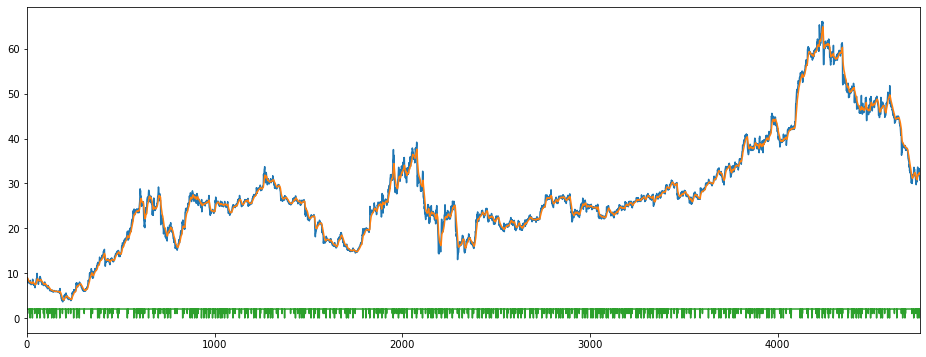

In [140]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [141]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [142]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(4750, 10, 4)

In [143]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [144]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [145]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [146]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [147]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2932 - accuracy: 0.4797 - mse: 0.4596 - weighted_accuracy: 0.3381 - weighted_mse: 0.5144 - val_loss: 0.3001 - val_accuracy: 0.0463 - val_mse: 0.3512 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3512
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2111 - accuracy: 0.3129 - mse: 0.7674 - weighted_accuracy: 0.4485 - weighted_mse: 0.7373 - val_loss: 0.2909 - val_accuracy: 0.0463 - val_mse: 0.3826 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3826
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1881 - accuracy: 0.2511 - mse: 1.0114 - weighted_accuracy: 0.5085 - weighted_mse: 0.9630 - val_loss: 0.2792 - val_accuracy: 0.0463 - val_mse: 0.4224 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.4224
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1798 - accuracy: 0.2355 - mse: 1.1881 - weighted_accuracy: 0.5280 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1378 - accuracy: 0.4076 - mse: 1.5567 - weighted_accuracy: 0.7012 - weighted_mse: 1.4742 - val_loss: 0.1839 - val_accuracy: 0.4042 - val_mse: 1.5663 - val_weighted_accuracy: 0.4042 - val_weighted_mse: 1.5663
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1374 - accuracy: 0.4368 - mse: 1.5586 - weighted_accuracy: 0.7155 - weighted_mse: 1.4938 - val_loss: 0.1923 - val_accuracy: 0.3800 - val_mse: 1.5360 - val_weighted_accuracy: 0.3800 - val_weighted_mse: 1.5360
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1356 - accuracy: 0.4366 - mse: 1.5660 - weighted_accuracy: 0.7136 - weighted_mse: 1.5007 - val_loss: 0.1951 - val_accuracy: 0.3663 - val_mse: 1.6342 - val_weighted_accuracy: 0.3663 - val_weighted_mse: 1.6342
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.4418 - mse: 1.5780 - weighted_accuracy: 0.7246 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.6005 - mse: 1.8486 - weighted_accuracy: 0.8099 - weighted_mse: 1.8298 - val_loss: 0.1757 - val_accuracy: 0.5221 - val_mse: 1.9417 - val_weighted_accuracy: 0.5221 - val_weighted_mse: 1.9417
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1096 - accuracy: 0.6016 - mse: 1.8670 - weighted_accuracy: 0.8122 - weighted_mse: 1.8460 - val_loss: 0.1621 - val_accuracy: 0.5653 - val_mse: 1.9486 - val_weighted_accuracy: 0.5653 - val_weighted_mse: 1.9486
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1087 - accuracy: 0.5832 - mse: 1.8983 - weighted_accuracy: 0.8144 - weighted_mse: 1.8896 - val_loss: 0.1745 - val_accuracy: 0.5411 - val_mse: 1.9422 - val_weighted_accuracy: 0.5411 - val_weighted_mse: 1.9422
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1095 - accuracy: 0.6145 - mse: 1.9029 - weighted_accuracy: 0.8150 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.7263 - mse: 2.4331 - weighted_accuracy: 0.8742 - weighted_mse: 2.4620 - val_loss: 0.1675 - val_accuracy: 0.6011 - val_mse: 2.5644 - val_weighted_accuracy: 0.6011 - val_weighted_mse: 2.5644
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0852 - accuracy: 0.6963 - mse: 2.4406 - weighted_accuracy: 0.8705 - weighted_mse: 2.4637 - val_loss: 0.1561 - val_accuracy: 0.6421 - val_mse: 2.6216 - val_weighted_accuracy: 0.6421 - val_weighted_mse: 2.6216
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0855 - accuracy: 0.7292 - mse: 2.4654 - weighted_accuracy: 0.8807 - weighted_mse: 2.4938 - val_loss: 0.1738 - val_accuracy: 0.5863 - val_mse: 2.4817 - val_weighted_accuracy: 0.5863 - val_weighted_mse: 2.4817
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0825 - accuracy: 0.7342 - mse: 2.4522 - weighted_accuracy: 0.8862 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0638 - accuracy: 0.8103 - mse: 3.2094 - weighted_accuracy: 0.9195 - weighted_mse: 3.2004 - val_loss: 0.1599 - val_accuracy: 0.7221 - val_mse: 3.5004 - val_weighted_accuracy: 0.7221 - val_weighted_mse: 3.5004
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0648 - accuracy: 0.8029 - mse: 3.2558 - weighted_accuracy: 0.9168 - weighted_mse: 3.2280 - val_loss: 0.1803 - val_accuracy: 0.6463 - val_mse: 3.4572 - val_weighted_accuracy: 0.6463 - val_weighted_mse: 3.4572
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0629 - accuracy: 0.8203 - mse: 3.2893 - weighted_accuracy: 0.9304 - weighted_mse: 3.2551 - val_loss: 0.1727 - val_accuracy: 0.6811 - val_mse: 3.4551 - val_weighted_accuracy: 0.6811 - val_weighted_mse: 3.4551
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0635 - accuracy: 0.8113 - mse: 3.3027 - weighted_accuracy: 0.9180 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0485 - accuracy: 0.8771 - mse: 4.5170 - weighted_accuracy: 0.9513 - weighted_mse: 4.3025 - val_loss: 0.1738 - val_accuracy: 0.7589 - val_mse: 5.0072 - val_weighted_accuracy: 0.7589 - val_weighted_mse: 5.0072
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0472 - accuracy: 0.8774 - mse: 4.5095 - weighted_accuracy: 0.9514 - weighted_mse: 4.2885 - val_loss: 0.1957 - val_accuracy: 0.6989 - val_mse: 5.0888 - val_weighted_accuracy: 0.6989 - val_weighted_mse: 5.0888
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.8695 - mse: 4.5765 - weighted_accuracy: 0.9485 - weighted_mse: 4.3424 - val_loss: 0.1831 - val_accuracy: 0.7358 - val_mse: 5.0637 - val_weighted_accuracy: 0.7358 - val_weighted_mse: 5.0637
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.8832 - mse: 4.7467 - weighted_accuracy: 0.9498 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9150 - mse: 6.2128 - weighted_accuracy: 0.9651 - weighted_mse: 5.6686 - val_loss: 0.2096 - val_accuracy: 0.7526 - val_mse: 6.4450 - val_weighted_accuracy: 0.7526 - val_weighted_mse: 6.4450
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9189 - mse: 6.3555 - weighted_accuracy: 0.9666 - weighted_mse: 5.7368 - val_loss: 0.2062 - val_accuracy: 0.7537 - val_mse: 6.5898 - val_weighted_accuracy: 0.7537 - val_weighted_mse: 6.5898
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9213 - mse: 6.3811 - weighted_accuracy: 0.9693 - weighted_mse: 5.8014 - val_loss: 0.2115 - val_accuracy: 0.7674 - val_mse: 7.3602 - val_weighted_accuracy: 0.7674 - val_weighted_mse: 7.3602
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9195 - mse: 6.4134 - weighted_accuracy: 0.9704 - 

In [148]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2406046837568283
Test accuracy: 0.7178947329521179


In [149]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-5.065776    0.5840727  -0.5432741 ]
 [-2.6919355  -3.4924853   1.3547015 ]
 [-3.6127825  -4.844237    3.1704235 ]
 ...
 [-0.06502432 -5.134905   -0.3535409 ]
 [-4.9970045  -5.0989466   3.467495  ]
 [-0.32903692 -0.9441525  -1.5456765 ]]


Counter({1: 103, 2: 734, 0: 113})

In [150]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 44})

In [151]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 7
actual buys but predicted sell: 4
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 34
actual holds but predicted buy: 95
actual holds but predicted sell: 101
actual predicted holds: 667
Percentage buys correct: 15.909090909090908%
Percentage sells correct: 18.6046511627907%
Percentage holds correct: 77.28852838933952%
actual buys: 44
actual sells: 43
actual holds: 863


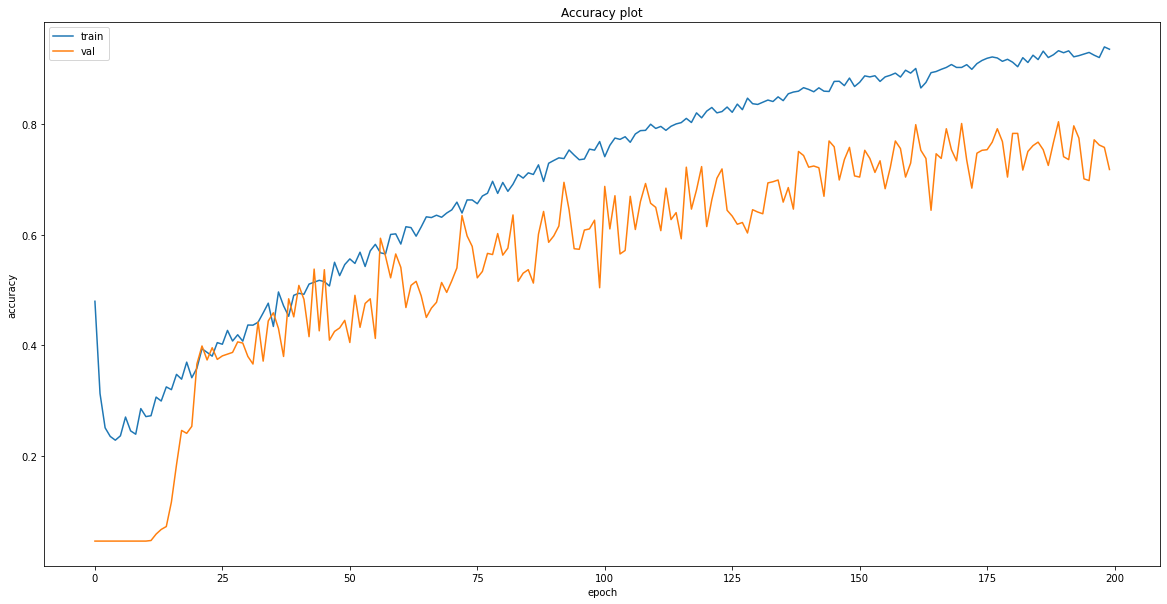

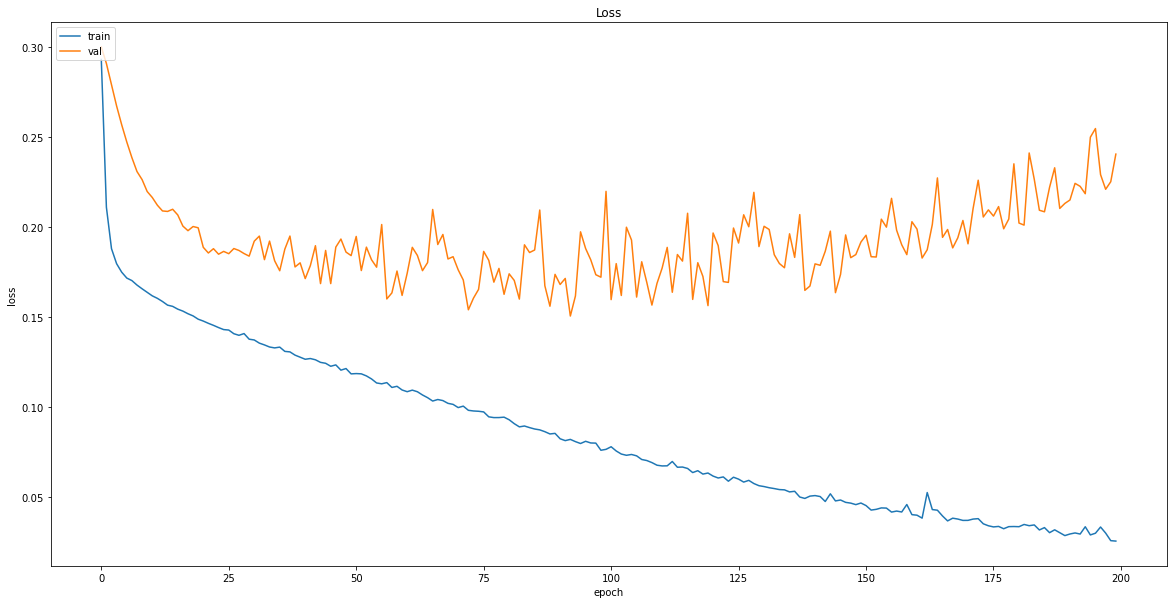

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [154]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,30.889999,30.367178,-27.586264,1834800.0,2.0
2019-01-30,31.139999,30.486073,-13.218461,1920100.0,2.0
2019-01-31,31.540001,30.648216,-15.486657,2046500.0,2.0
2019-02-01,31.980000,30.853106,-5.241975,2142700.0,2.0
2019-02-04,32.009998,31.031089,-10.188698,2253700.0,2.0


In [155]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(218, 10, 4)

In [156]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [157]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.7523 - mean_squared_error: 9.1316 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 9.1316
Test loss: 0.21817003190517426
Test accuracy: 0.752293586730957


In [158]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 24, 2: 176, 1: 18})

In [159]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [160]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,0,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


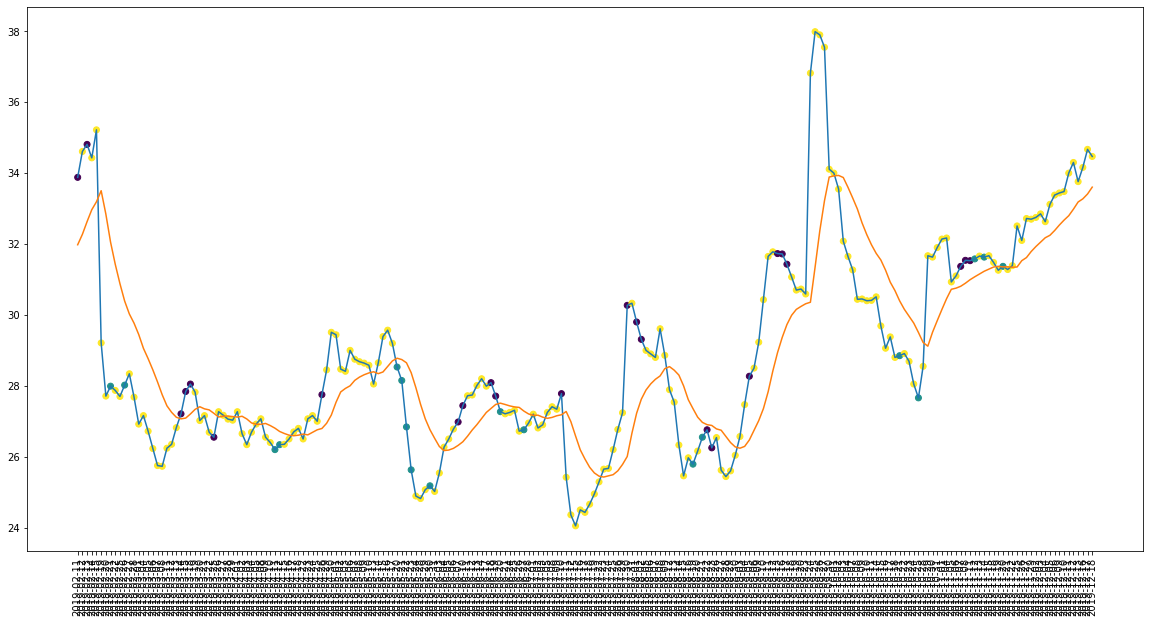

In [161]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

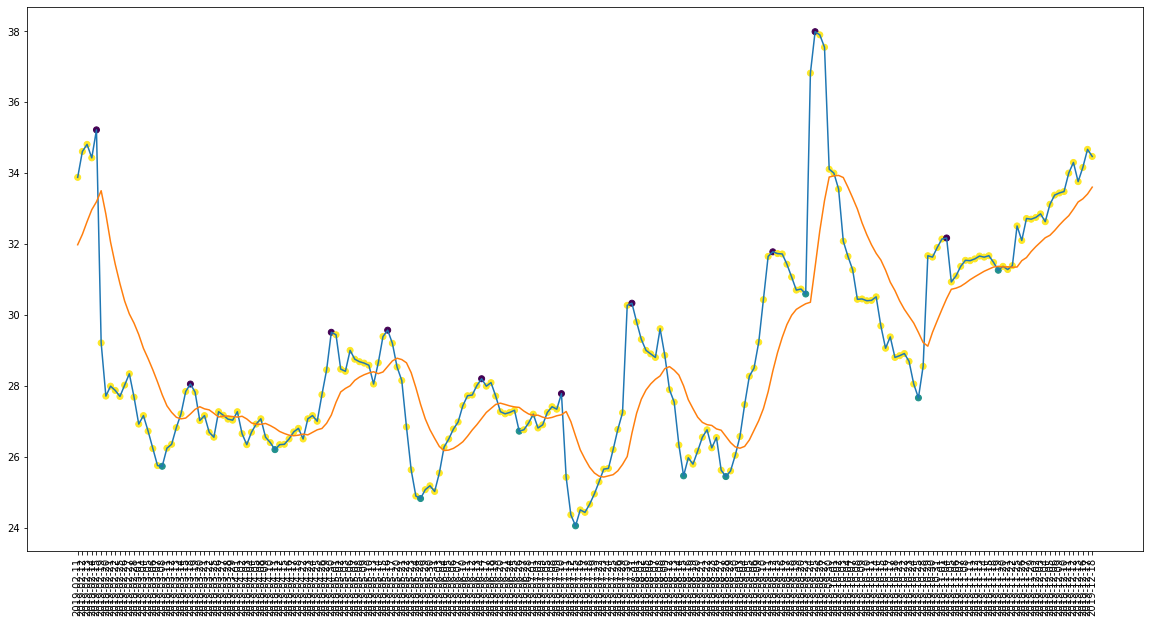

In [162]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [163]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 16
actual holds but predicted sell: 22
actual predicted holds: 160
Percentage buys correct: 20.0%
Percentage sells correct: 20.0%
Percentage holds correct: 80.8080808080808%
actual buys: 10
actual sells: 10
actual holds: 198


In [164]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 50.0%
Percentage holds correct: 83.42857142857143%


In [165]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $26.20000076293945
Shares owned at the moment: 364
Cash capital at the moment: $2.29674031830109


Price increase from previously bought: 5.625557167883133%
Share price: $27.75
Shares owned at the moment: 0
Cash capital at the moment: $10075.5189903183


Share price: $28.53000068664551
Shares owned at the moment: 352
Cash capital at the moment: $5.341707954406957


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9427.040641517639


Share price: $26.84000015258789
Shares owned at the moment: 350
Cash capital at the moment: $7.207087965010942


Stop Loss Activated!

Share price: $25.6299991607666
Shares owned at the moment: 0
Cash capital at the moment: $8953.03792004

In [166]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [167]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,32.560001,33.556203,-73.873848,-176200.0,2.0
2020-01-30,31.620001,33.258326,-99.415191,-270900.0,2.0
2020-01-31,31.770000,33.029353,-86.898401,-180300.0,2.0
2020-02-03,31.379999,32.775606,-90.547286,-321500.0,2.0
2020-02-04,31.900000,32.640897,-77.611952,-129800.0,1.0


In [168]:
labels = []
data_10 = []
sequential = []
count = 0

for i in df.values:
    if count == 9:
        data_10.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_arr = min_max_scaler.fit_transform(data_10)
        sequential.append(data_10_arr)
        data_10 = data_10[1:10]
    else:
        data_10.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 10, 4)
y = labels
y = np.array(y)
X.shape

(219, 10, 4)

In [169]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [170]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2337 - accuracy: 0.7306 - mean_squared_error: 7.4737 - weighted_accuracy: 0.7306 - weighted_mean_squared_error: 7.4737
Test loss: 0.2336651235818863
Test accuracy: 0.7305936217308044


In [171]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 0: 33, 1: 11})

In [172]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [173]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,0,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


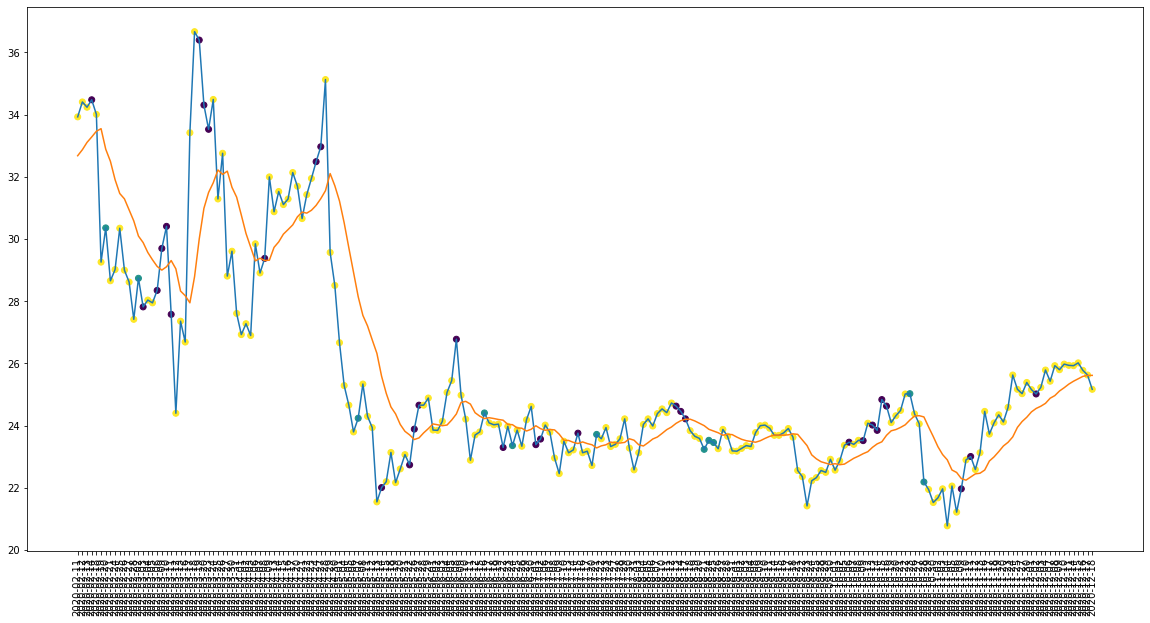

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

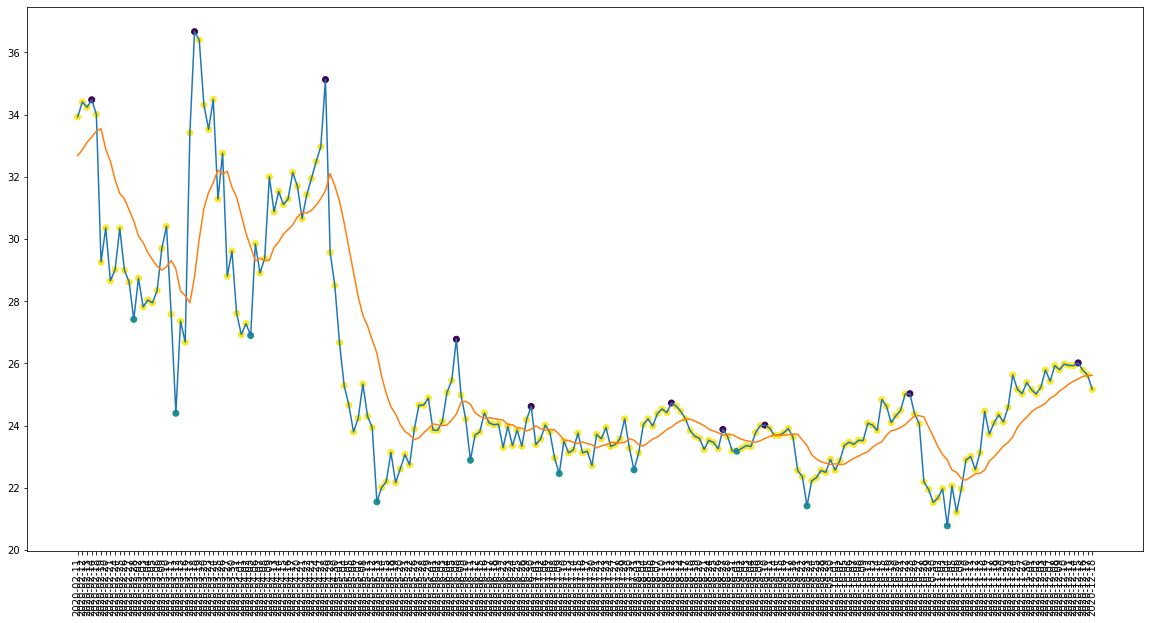

In [175]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [176]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 10
actual holds but predicted sell: 31
actual predicted holds: 158
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 79.39698492462311%
actual buys: 10
actual sells: 10
actual holds: 199


In [177]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 83.9080459770115%


In [178]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.36000061035156
Shares owned at the moment: 328
Cash capital at the moment: $14.535079254152151


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9389.163709342958


Share price: $28.739999771118164
Shares owned at the moment: 325
Cash capital at the moment: $22.977408934117193


Stop Loss Activated!

Share price: $27.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9039.613185024738


Share price: $24.239999771118164
Shares owned at the moment: 371
Cash capital at the moment: $21.842410173416283


Stop Loss Activated!

Share price: $21.549999237060547
Shares owned at the moment: 0
Cash capital at the moment: $7994.905740401268


Share price: $24.40999984741211
Shares owned at the moment: 326
Cash capital at the moment: $15.362225281715837


Stop Loss Activated!

Share price: $23.29999923706055
Shares owned at the moment: 0
Cash capital at the moment: $7590.27352724743


Share pric

In [179]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
